# Fetal Liver Hematopoiesis
Last updated May 9, 2021

This notebook reproduces the figures in the Symphony publication. The data was obtained from the following paper:

Original publication: https://www.nature.com/articles/s41586-019-1652-y#Sec37
(Popescu et al., Nature 2019)

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
})

In [2]:
# Colors for each cell state
group.colors = c(   'B cell'='#f2bd80',
                    'DC precursor'='#1d6d1f',
                    'DC1'='#8c3ba0',
                    'DC2'='#6533ed',
                    'Early Erythroid'='#83e3f0',
                    'Early lymphoid/T'='#fd5917',
                    'Endothelial cell'='#4f8c9d',
                    'Fibroblast'='#eb1fcb',
                    'Hepatocyte'='#f5cdaf',
                    'HSC_MPP'='#9698dc',
                    'ILC precursor'='#20f53d',
                    'Kupffer Cell'='#f283e3',
                    'Late Erythroid'='#ffb2be',
                    'Mast cell'='#f3d426',
                    'Megakaryocyte'='#5ebf72',
                    'MEMP'='#a67649',
                    'Mid Erythroid'='#2f5bb1',
                    'Mono-Mac'='#90a479',
                    'Monocyte'='#f6932e',
                    'Monocyte precursor'='#d59e9a',
                    'Neut-myeloid prog.'='#caf243',
                    'NK'='#38b5fc',
                    'pDC precursor'='#c82565',
                    'Pre pro B cell'='#d6061a',
                    'pre-B cell'='#e36f6f',
                    'pro-B cell'='#1dfee1',
                    'VCAM1+ EI macro.'='#506356')

# Data info

**3-prime data**
Post-filtering and post-doublet-removal data was obtained by contacting the original authors (Haniffa lab). 
Cell type labels were obtained from Supplementary Table 5 (Popescu et al 2019).

**5-prime data**
Filtered and doublet-removed data as well as cell type labels was obtained from the original authors. Removed donors F2 and F5 due to low library complexity (3953 cells).

## Plot cell counts by donor and cell type

Load data

In [3]:
exprs_3p = readRDS('../data/Fig5_fetal_liver/exprs_3p.rds')
exprs_5p = readRDS('../data/Fig5_fetal_liver/exprs_5sync_filtered.rds')
metadata_3p = readRDS('../data/Fig5_fetal_liver/metadata_3p.rds')
metadata_5p = readRDS('../data/Fig5_fetal_liver/metadata_5p_sync_filtered.rds') # obtained from authors

dim(exprs_3p)
dim(exprs_5p)
dim(metadata_3p)
dim(metadata_5p)

[1]  27080 113063

[1] 33694 21414

[1] 113063     18

[1] 21414    14

In [4]:
# Shorter cell type labels
metadata_3p$cell.labels = plyr::mapvalues(metadata_3p$cell.labels, 
    from = c('Early lymphoid_T lymphocyte', 'Neutrophil-myeloid progenitor', 'VCAM1+ EI macrophage'),
    to = c('Early lymphoid/T', 'Neut-myeloid prog.', 'VCAM1+ EI macro.'))
metadata_5p$cell.labels = plyr::mapvalues(metadata_5p$cell.labels,
    from = c('Neutrophil-myeloid progenitor', 'VCAM1+ EI macrophage'),
    to = c('Neut-myeloid prog.', 'VCAM1+ EI macro.'))

In [5]:
# Add label with donor and pcw together
metadata_3p$donor_pcw = paste(metadata_3p$donor, ' (', metadata_3p$pcw, ')', sep = '')
counts_3p = metadata_3p %>% dplyr::count(donor_pcw, cell.labels) 

# Reorder factor levels by most abundant cell type
counts_3p$cell.labels = reorder(counts_3p$cell.labels, counts_3p$n)

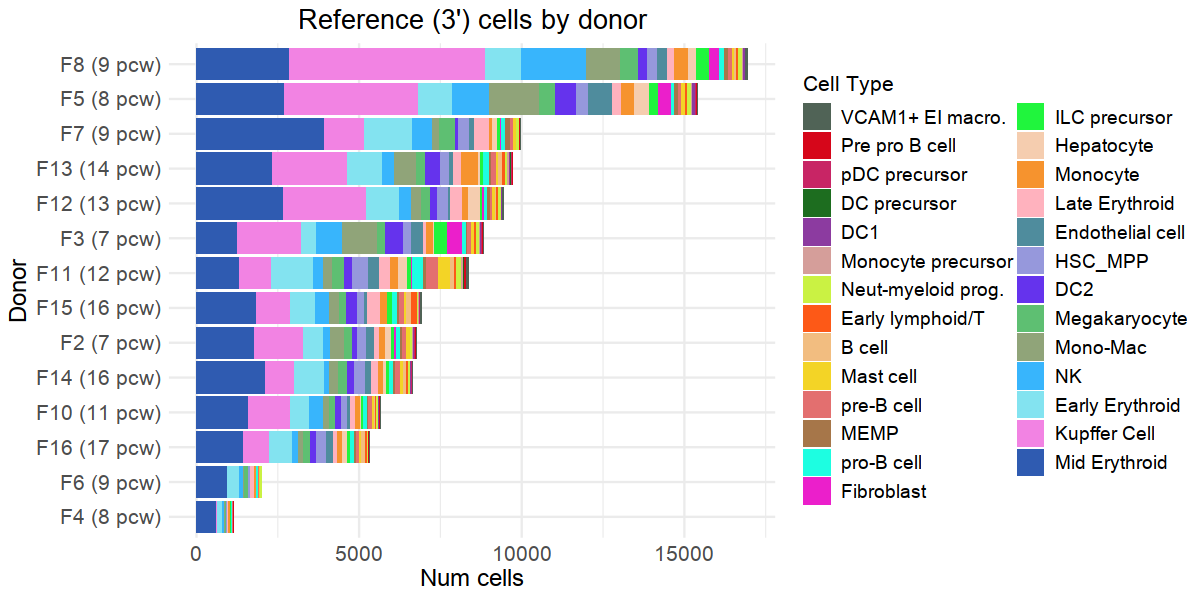

In [6]:
fig.size(5, 10)

p = ggplot(data = counts_3p, aes(x=reorder(donor_pcw, n, FUN = sum), y = n, fill = cell.labels)) +
  geom_bar(stat="identity") +
  scale_fill_manual(values = group.colors)+
  theme_minimal() +
  labs(x = 'Donor', y = 'Num cells', title = "Reference (3') cells by donor", fill = 'Cell Type') +
  theme(plot.title = element_text(size = 16, hjust = 0.5)) + 
  theme(legend.text = element_text(size=11), legend.title = element_text(size = 12), 
        axis.title = element_text(size = 14), axis.text = element_text(size = 12)) +
  coord_flip()
p

# Build 3-prime reference with Symphony

In [7]:
head(metadata_3p, 4)

cell.barcode,cell.labels,organ,facs.sort,Source.Name,cell_barcode,nGene,nUMI,orig.ident,percent.mito,stages,gender,doublets,combined.labels,batch,sample,donor,pcw,donor_pcw
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<chr>
F14_liver_CD45+_FCAImmP7179363_AAACCTGAGCAGATCG,Kupffer Cell,liver,CD45+,FCAImmP7179363,AAACCTGAGCAGATCG,2880,12998,2,0.03038929,3,1,0,11,5,5,F14,16 pcw,F14 (16 pcw)
F14_liver_CD45+_FCAImmP7179363_AAGACCTGTGGCAAAC,Kupffer Cell,liver,CD45+,FCAImmP7179363,AAGACCTGTGGCAAAC,2276,8431,2,0.04151346,3,1,0,11,5,5,F14,16 pcw,F14 (16 pcw)
F14_liver_CD45+_FCAImmP7179363_AATCGGTCAATGTAAG,Kupffer Cell,liver,CD45+,FCAImmP7179363,AATCGGTCAATGTAAG,2260,8904,2,0.03043576,3,1,0,11,5,5,F14,16 pcw,F14 (16 pcw)
F14_liver_CD45+_FCAImmP7179363_AATCGGTCAATTGCTG,Kupffer Cell,liver,CD45+,FCAImmP7179363,AATCGGTCAATTGCTG,2207,9015,2,0.05224626,3,1,0,11,5,5,F14,16 pcw,F14 (16 pcw)


Normalize data (log CP10k)

In [8]:
exprs_3p_norm = singlecellmethods::normalizeData(exprs_3p, 1e4, 'log')

Select variable genes

Follow the original authors' variable gene selection process: https://github.com/haniffalab/FCA_liver/blob/master/pipelines/06_add_dr/add_dr.R

In [9]:
groups = rep('A', ncol(exprs_3p_norm))
vargenes = singlecellmethods::findVariableGenes(exprs_3p_norm, groups = groups, min_expr = .0125, max_expr = 3, min_dispersion = 0.625)

# FindVariableGenes(object = seurat.obj, mean.function = ExpMean, 
#                                 dispersion.function = LogVMR, x.low.cutoff = .0125, 
#                                 x.high.cutoff = 3, y.cutoff = .625)

In [10]:
head(vargenes, 4)
nrow(vargenes)

symbol,group,gene_mean,gene_dispersion,gene_dispersion_scaled
<fct>,<chr>,<dbl>,<dbl>,<dbl>
HBE1,A,0.5387957,6.425401,8.018453
APOA2,A,2.7971375,6.271111,2.456329
CLC,A,0.4079142,6.122133,7.614879
S100A8,A,1.5228720,5.799203,4.039391


[1] 1917

PCA embedding

In [11]:
ref_exp = exprs_3p_norm[vargenes$symbol, ]
vargenes_means_sds = tibble(symbol = vargenes$symbol, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

In [12]:
set.seed(123)
# Run SVD, save gene loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs x cells]
loadings = s$u

Harmony

Warning message:
“did not converge in 25 iterations”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5653150)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5653150)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5653150)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5653150)”Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony 6/10
Harmony 7/10
Harmony 8/10
Harmony 9/10
Harmony 10/10
Harmony converged after 10 iterations


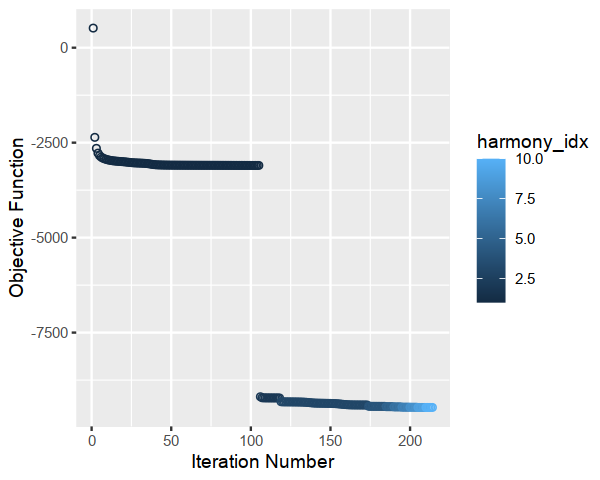

In [13]:
fig.size(4, 5)
set.seed(123)
# Harmonize the reference
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref), ## PCA embedding matrix of cells
        meta_data = metadata_3p, ## dataframe with cell labels
        theta = c(3),            ## cluster diversity enforcement
        vars_use = c('donor'),   ## variable to integrate out
        nclust = 100,            ## number of clusters in Harmony model
        max.iter.harmony = 10,
        return_object = TRUE,    ## return the full Harmony model object
        do_pca = FALSE,          ## do not recompute PCs
        plot_convergence = TRUE
)

Symphony compression

In [14]:
# Compress Harmony obj into a Symphony reference
reference = buildReferenceFromHarmonyObj(
                ref_harmObj,            # output object from HarmonyMatrix()
                metadata_3p,
                vargenes_means_sds,     # gene names, means, and std devs for scaling
                loadings,               # genes x PCs
                verbose = TRUE, 
                do_umap = FALSE )

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
Finished nicely.


UMAP embedding

In [16]:
# Run UMAP using Seurat default parameters
set.seed(123)
my_umap = uwot::umap(
            t(reference$Z_corr[1:20, ]), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
            metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1, # for reproducibility
            min_dist = 0.3, n_threads = 4, ret_model = TRUE)

In [17]:
# Save UMAP model
save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/fetal_liver_uwot_model'
model = uwot::save_uwot(my_umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
save_uwot_path = '../pre-built_references/fetal_liver_uwot_model'
reference$save_uwot_path = save_uwot_path

Warning message:
“invalid uid value replaced by that for user 'nobody'”

Due to how uwot was designed, the uwot model must be saved as a separate file. Therefore,
in order to map to the reference and visualize with reference UMAP coordinates, 
you need to update the `reference$save_uwot_path` with the path to the desired uwot model.
i.e. replace `../pre-built_references/fetal_liver_uwot_model` with your own path.

In [18]:
# Save UMAP coordinates
colnames(my_umap$embedding) = c('UMAP1', 'UMAP2')
reference$umap = my_umap

Save Symphony reference

In [19]:
saveRDS(reference, '../pre-built_references/fetal_liver_reference_3p.rds')

## Plot reference cells UMAP

In [15]:
reference = readRDS('../pre-built_references/fetal_liver_reference_3p.rds')

In [16]:
# Join metadata and UMAP coordinates
umap_labels = cbind(reference$meta_data, reference$umap$embedding) %>%
    mutate(cell.labels = fct_relevel(cell.labels, 
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte',
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid',
            'Endothelial cell', 'Fibroblast', 'Hepatocyte'))

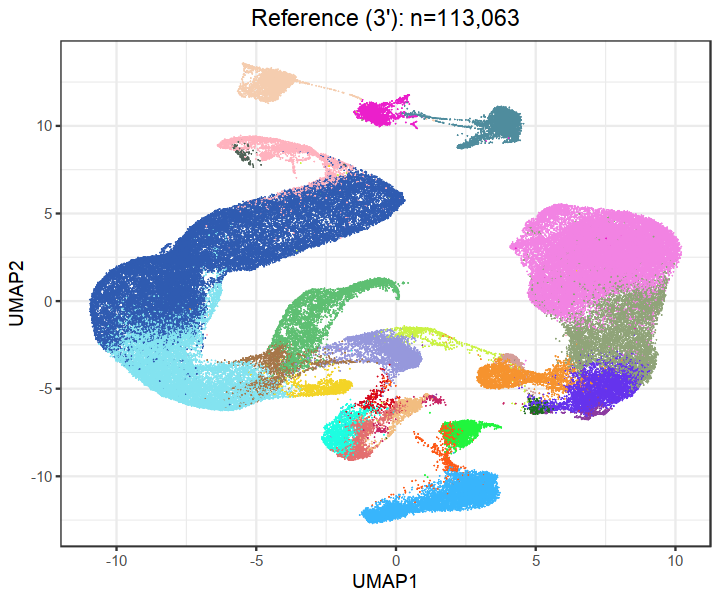

In [17]:
fig.size(5, 6)
umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell.labels)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference (3\'): n=113,063', color = 'Cell Type') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position="none") +
    scale_colour_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 2))

## Plot compressed reference

In [18]:
# Add centroid locations
centroids = reference$Z_corr %*% t(reference$R)
ref_umap_model = uwot::load_uwot(reference$save_uwot_path, verbose = FALSE)
umap_centroids = uwot::umap_transform(t(centroids), ref_umap_model) %>% as.data.frame()
colnames(umap_centroids) = c('UMAP1', 'UMAP2')

In [19]:
# Add UMAP coordinates to metadata
colnames(reference$umap$embedding) = c('UMAP1', 'UMAP2')
umap_labels = cbind(reference$meta_data, reference$umap$embedding) %>%
    mutate(cell.labels = fct_relevel(cell.labels, 
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte',
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid',
            'Endothelial cell', 'Fibroblast', 'Hepatocyte')) %>% # match order of original pub
    sample_frac(1L) # permute rows randomly

In [20]:
# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
  dplyr::group_by(cell.labels) %>%
  dplyr::select(UMAP1, UMAP2) %>% 
  summarize_all(median)
labels.cent$num = c(1:27)

Adding missing grouping variables: `cell.labels`


png 
  2

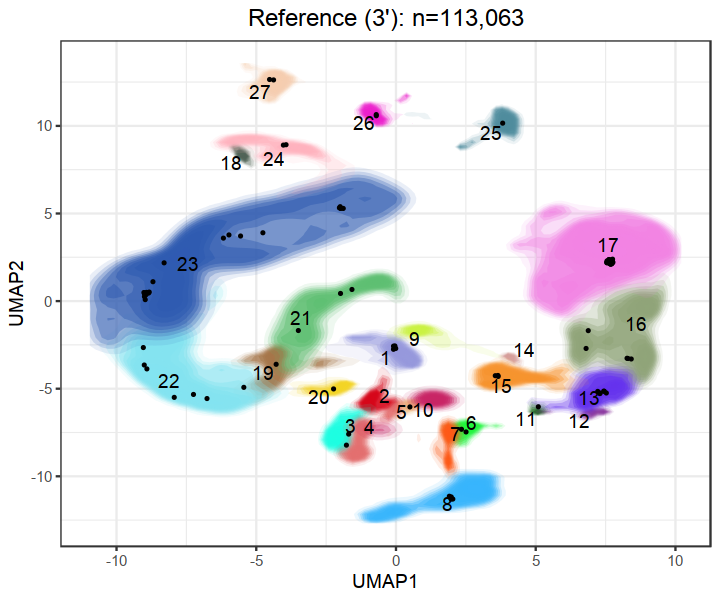

In [21]:
pdf('figs/reference_density_wcentroids.pdf', width = 6, height = 5, useDingbats = FALSE)
fig.size(5, 6)

p = ggplot(umap_labels, aes(x = UMAP1, y = UMAP2)) +
    stat_density_2d(geom = 'polygon', aes(alpha = ..level.., fill = cell.labels), 
                    contour_var = "ndensity", bins = 12) +
    geom_point(data = umap_centroids, aes(x = UMAP1, y = UMAP2), size = 0.4) +
    theme_bw() +
    labs(title = 'Reference (3\'): n=113,063', color = '', fill = '') + 
    theme(plot.title = element_text(hjust = 0.5, size = 14), legend.position="none") +
    scale_fill_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 5), ncol = 5)) +
    ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = num), 
                segment.alpha = 0.5, segment.size = 0.2,
                box.padding = 0.01, color = 'black')
print(p)
dev.off()
p

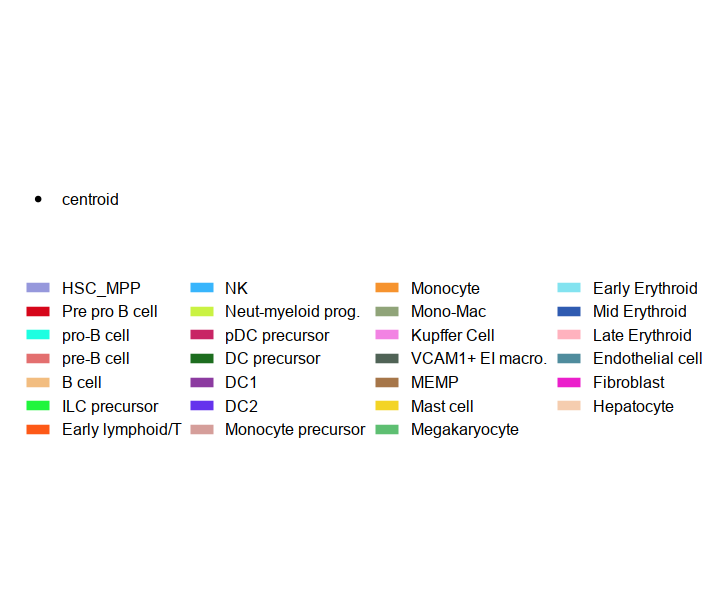

In [22]:
p = ggplot() +
    geom_density_2d(data = umap_labels, contour_var = 'ndensity', 
                    aes(x = UMAP1, y = UMAP2, col = cell.labels), size = 0.3, bins = 12) +
    geom_point(data = umap_centroids, aes(x = UMAP1, y = UMAP2, fill = 'centroid'), size = 0.8) +
    theme_bw() + labs(color = '', fill = '') + 
    theme(legend.position="right", legend.text = element_text(size=9)) +
    scale_colour_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 2), ncol = 4, 
                                 keyheight=0.5, default.unit="cm"))

my_legend = get_legend(p)
as_ggplot(my_legend)

# Mapping 5-prime cells onto reference

Read in reference

In [67]:
reference = readRDS('../pre-built_references/fetal_liver_reference_3p.rds')

Symphony mapping

In [68]:
metadata_5p$end.bias = '5prime' # add covariate

In [69]:
# Map query
ptm <- proc.time()
query = mapQuery(exprs_5p, metadata_5p, reference, 
                 vars = c('donor', 'end.bias'), 
                 do_normalize = TRUE)
proc.time() - ptm

Normalizing
Scaling and synchronizing query gene expression
Found 1917 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


   user  system elapsed 
 24.690  11.440  16.181 

## Plot mapping

In [70]:
# Sync column names
r_metadata = reference$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = q_metadata$donor
meta_data_combined = rbind(q_metadata, r_metadata)

In [71]:
# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# To plot query cells on top
umap_combined_labels = umap_combined_labels[order(-as.numeric(factor(umap_combined_labels$ref_query))),]

png 
  2

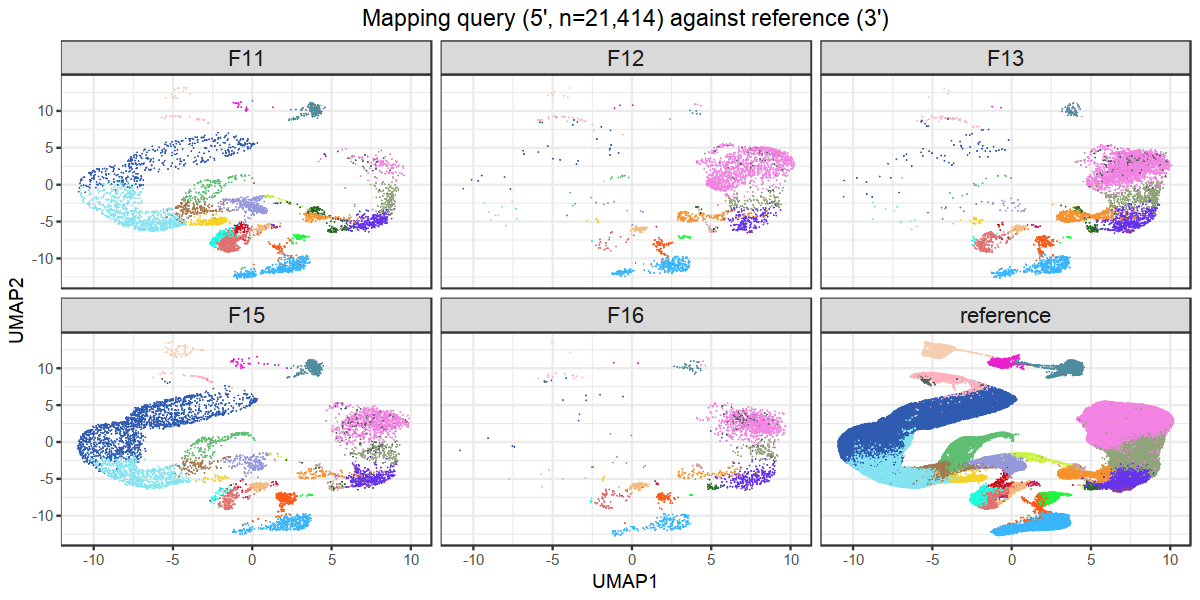

In [72]:
pdf(paste('figs/umap_map5p_colorbycelltype.pdf', sep = ''), height = 5, width=10, useDingbats = FALSE)
fig.size(5, 10)

q = umap_combined_labels %>%
    mutate(cell.labels = fct_relevel(cell.labels, 
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte', 
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid',
            'Endothelial cell', 'Fibroblast', 'Hepatocyte')) %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell.labels)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Mapping query (5\', n=21,414) against reference (3\')', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position="none") +
    scale_colour_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    theme(strip.text.x = element_text(size=13)) +
    facet_wrap(~ref_query)
print(q)
dev.off()
q

# Cell type classification

## Varying k

In [76]:
varying_k_res = data.frame(k = c(5, 10, 30, 100, 200, 400), MedF1 = rep(0, 6), Acc = rep(0, 6))
for (k in c(1:nrow(varying_k_res))) {
    col_label = paste0('cell_type_pred_knn_', varying_k_res[k, 'k'])
    query = knnPredict(query, reference, reference$meta_data$cell.labels,
                       k = varying_k_res[k, 'k'],
                       save_as = col_label,
                       confidence = TRUE)
    res = symphony:::evaluate(query$meta_data$cell.labels, query$meta_data[col_label])
    varying_k_res[k, 'MedF1'] = res$MedF1
    varying_k_res[k, 'Acc'] = res$Acc
}
varying_k_res

k,MedF1,Acc
<dbl>,<dbl>,<dbl>
5,0.8192771,0.8458485
10,0.8395062,0.8467825
30,0.8301887,0.8496778
100,0.8333333,0.8500514
200,0.8489209,0.8489773
400,0.7998768,0.8434669


In [78]:
saveRDS(query, 'figs/query.rds')

png 
  2

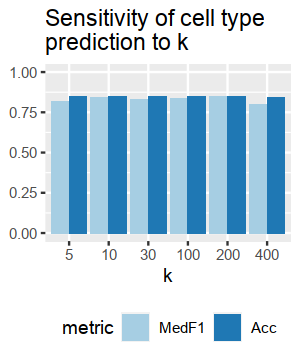

In [165]:
varying_k_res$k = as.factor(varying_k_res$k)
varying_k_res_long = gather(varying_k_res, metric, value, MedF1:Acc, factor_key=TRUE)

fig.size(3, 2.5)
pdf(paste('figs/kNN_range.pdf', sep = ''), height = 3,  width = 2.5, useDingbats=FALSE)
p = ggplot(varying_k_res_long) +
    geom_bar(aes(x = k, y = value, fill = metric), position="dodge", stat="identity") + 
    ylim(0, 1) + ylab(NULL) + ggtitle('Sensitivity of cell type\nprediction to k') +
    theme(legend.position = 'bottom') + scale_fill_brewer(palette = 'Paired')
print(p)
dev.off()
print(p)

30-NN cell type prediction

In [82]:
# Predict query cell types
query = knnPredict(query, reference, 
                   train_labels = reference$meta_data$cell.labels, k = 30, confidence = TRUE)

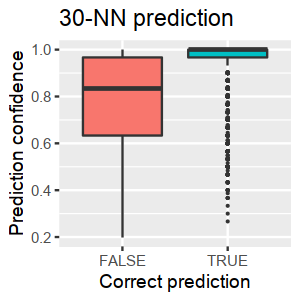

In [107]:
fig.size(2.5, 2.5)
query$meta_data$correct_pred = (query$meta_data$cell.labels == query$meta_data$cell_type_pred_knn_30)
p = query$meta_data %>% ggplot() +
        geom_boxplot(aes(x = correct_pred, y = cell_type_pred_knn_30prob, fill = correct_pred), outlier.size = 0.1) + 
        xlab('Correct prediction') + ylab('Prediction confidence') + theme(legend.position = "none") +
        ggtitle('30-NN prediction')
p

Cells that are incorrectly predicted have lower prediction confidence scores.

## Calculate accuracy metrics

In [138]:
res = symphony:::evaluate(query$meta_data$cell.labels, query$meta_data$cell_type_pred_knn)
res$F1
print(paste('Accuracy:', res$Acc))
print(paste('Median F1:', res$MedF1))

B cell       DC precursor                DC1                DC2 
        0.85245902         0.41059603         0.80662983         0.81925344 
   Early Erythroid   Early lymphoid/T   Endothelial cell         Fibroblast 
        0.90057361         0.60157791         0.98426573         0.92982456 
        Hepatocyte            HSC_MPP      ILC precursor       Kupffer Cell 
        1.00000000         0.90769231         0.46433991         0.94011698 
    Late Erythroid          Mast cell      Megakaryocyte               MEMP 
        0.88401254         0.98064516         0.87822878         0.62955854 
     Mid Erythroid           Mono-Mac           Monocyte Monocyte precursor 
        0.93406593         0.77656250         0.86644327         0.29019608 
Neut-myeloid prog.                 NK      pDC precursor     Pre pro B cell 
        0.55958549         0.98423237         0.83018868         0.73446328 
        pre-B cell         pro-B cell   VCAM1+ EI macro. 
        0.67790082         0.51087985         0.03143418

[1] "Accuracy: 0.849677780891006"
[1] "Median F1: 0.830188679245283"


## Plot confusion matrix as heatmap

Cluster cell types by average raw expression for ordering heatmap

In [139]:
# Calculate the average expression per cell type
exprs_5p_norm = singlecellmethods::normalizeData(exprs_5p, 1e4, 'log')

avg_exprs = NULL
for (cell_type in unique(metadata_5p$cell.labels)) {
    indices = which(metadata_5p$cell.labels == cell_type)
    exprs_type = exprs_5p_norm[, indices]
    exprs_mean = rowMeans(exprs_type)
    avg_exprs = cbind(avg_exprs, exprs_mean)
}
colnames(avg_exprs) = unique(metadata_5p$cell.labels)

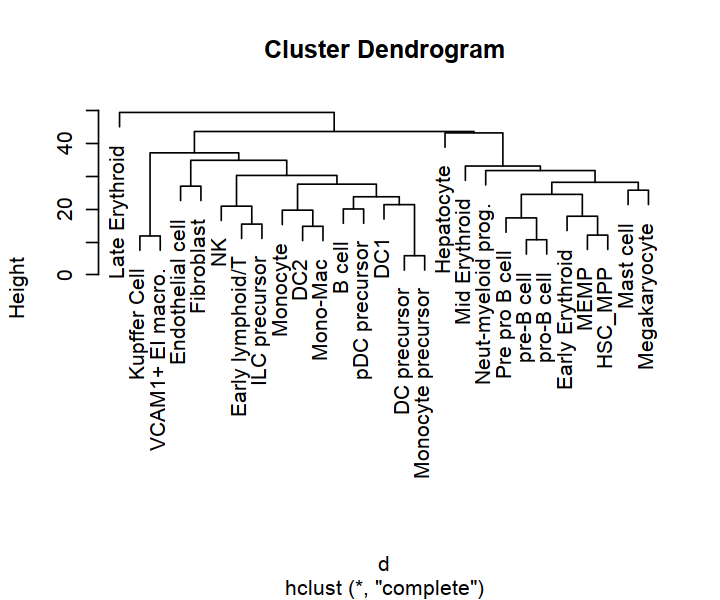

In [140]:
fig.size(5,6)
d = dist(as.matrix(t(avg_exprs)))   # find distance matrix 
hc = hclust(d)                      # apply hirarchical clustering 
plot(hc)

In [141]:
#library(devtools)
#install_github("jokergoo/ComplexHeatmap")
#install.packages('dendextend')
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(circlize)
    library(dendextend)
})

Confusion matrix

In [142]:
cm = table(Actual = query$meta_data$cell.labels, Predicted = query$meta_data$cell_type_pred_knn)
write.csv(cm,'figs/conf_mat_5p-to-3p.csv')

In [143]:
# Calculate proportion of correctly predicted cells
cellSums = rowSums(cm)
cm_prop = cm / cellSums
cm_prop =  cm_prop %>% as.data.frame()

m = as.data.frame(cm_prop) %>% 
        spread(Predicted, Freq)
rownames(m) = m$Actual
m$Actual = NULL

# Make barplot data
numcells = rowSums(cm)
numcells = numcells[hc$labels]

# Order rows and columns according to dendrogram
m = m[hc$labels, ]
m = m[, rownames(m)[hc$order]]

In [144]:
pdf('figs/conf_mat_5p3p_knn30.pdf', height = 5.5, width = 8, useDingbats = FALSE)
fig.size(5.5, 8)

breaks = c(50, 500, 5000)
ha = rowAnnotation(num_cells = anno_barplot(log10(numcells) - 1.2, bar_width = 0.8, width = unit(2.5, "cm"),
                   axis_param = list(at = log10(breaks) - 1.2, labels = breaks)))

ht = Heatmap(as.matrix(m), 
        col = colorRamp2(c(0, 0.5, 1), c("dodgerblue3", "white", "firebrick2" )),
        cluster_rows = as.dendrogram(hc), column_order = colnames(m),
        row_dend_side = "left", show_column_dend = FALSE,
        column_title = "Predicted cell type based on mapping to reference (3')", 
        row_title = "Query (5') true cell type",
        row_title_side = "left", column_title_side = "bottom", row_names_side = "left",
        row_title_gp = gpar(fontsize = c(12)), column_title_gp = gpar(fontsize = c(12)),
        row_names_gp = gpar(fontsize = c(9)), column_names_gp = gpar(fontsize = c(9)),
        heatmap_legend_param = list(title = "prop. cells", legend_height = unit(3, "cm"), 
                                    at = c(0, 0.25, 0.5, 0.75, 1)),
        right_annotation = ha)

draw(ht, column_title = "5'-to-3' experiment: Confusion matrix (30-NN)", column_title_gp = gpar(fontsize = 14))

dev.off()
draw(ht, column_title = "5'-to-3' experiment: Confusion matrix (30-NN)", column_title_gp = gpar(fontsize = 14))

png 
  2

# Trajectory analysis with FDG

Read in FDG coordinates (obtained from original authors)

In [145]:
fdg = read.csv('../data/Fig5_fetal_liver/adata_fdg_coords.csv')
colnames(fdg) = c('cell.barcode', 'FDG1', 'FDG2')
new_metadata = cbind(reference$meta_data, fdg[,2:3])

## Restrict to immune cells only
idx_remove_cells = which(reference$meta_data$cell.labels 
                         %in% c('Fibroblast', 'Hepatocyte', 'Endothelial cell'))
new_metadata = new_metadata[-idx_remove_cells,]
Z_ref = reference$Z_corr[, -idx_remove_cells]

## Reorder factors
new_metadata$cell.labels = droplevels(new_metadata$cell.labels)
new_metadata$cell.labels = fct_relevel(new_metadata$cell.labels, 
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte',
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid')

Plot reference FDG trajectory

In [146]:
# Add cell type labels
labels.cent = new_metadata %>% 
  dplyr::group_by(cell.labels) %>%
  dplyr::select(FDG1, FDG2) %>% 
  summarize_all(median)
labels.cent$num = c(1:24)

Adding missing grouping variables: `cell.labels`


Warning message:
“Removed 1 rows containing missing values (geom_point).”

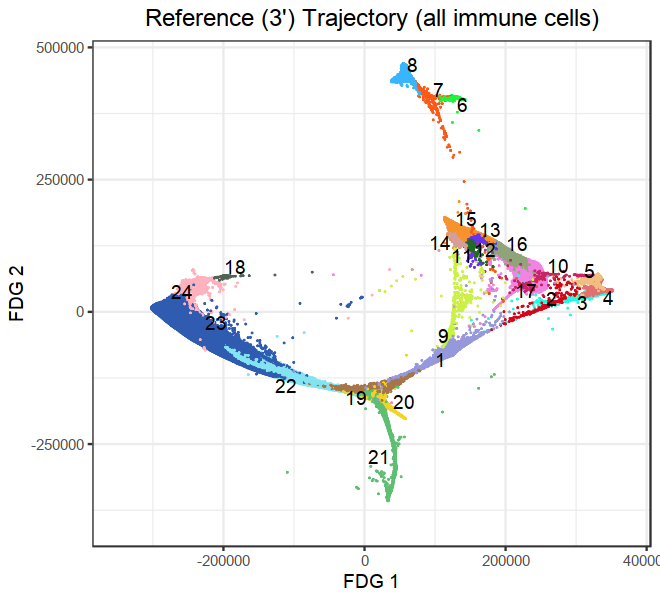

In [147]:
options(scipen=10000)
fig.size(5, 5.5)
q =  new_metadata %>% 
        ggplot(aes(x = FDG1, y = FDG2)) +
        geom_point_rast(aes(x = FDG1, y = FDG2, col = cell.labels), 
                        size = 0.6, stroke = 0.2, shape = 16) +
        theme_bw() + 
        theme(legend.position = 'none') +
        scale_color_manual(values = group.colors) +
        labs(x = "FDG 1", y = "FDG 2", color = 'Cell type') + 
        theme(legend.position="none", plot.title = element_text(size=14), 
        legend.text = element_text(size=10)) + 
        guides(color=guide_legend(keyheight=0.5, default.unit="cm",
                                  override.aes = list(size = 3), ncol = 1)) +
        labs(title = "Reference (3') Trajectory (all immune cells)") + 
        theme(plot.title = element_text(hjust = 0.5), legend.key.size = unit(0.9, 'lines')) +
        xlim(-350000, 370000) + ylim(-400000, 470000) +
        ggrepel::geom_text_repel(data = labels.cent, aes(x= FDG1, y = FDG2, label = num), 
                segment.alpha = 0.5, segment.size = 0.2,
                box.padding = 0.01, color = 'black', nudge_y = 0.1)
q

## Map query subset (MEM only) onto trajectory

In [148]:
# Filter query to only include cells in the mast cell, erythroid, megakaryocyte lineage
mem_list = c('MEMP', 'Mast cell', 'Megakaryocyte', 'Early Erythroid', 
             'Mid Erythroid', 'Late Erythroid')
idx_include_cells = which(metadata_5p$cell.labels %in% mem_list)
exprs_5p_subset = exprs_5p[, idx_include_cells]
metadata_5p_subset = metadata_5p[ idx_include_cells, ]
dim(exprs_5p_subset)

[1] 33694  5141

In [149]:
# Map query
ptm = proc.time()
query = mapQuery(exprs_5p_subset, metadata_5p_subset, reference, 
                 vars = c('donor', 'end.bias'), do_normalize = TRUE)
proc.time() - ptm

Normalizing
Scaling and synchronizing query gene expression
Found 1917 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


   user  system elapsed 
  6.316   4.535   4.364 

Predict trajectory coordinates using k-NN

In [150]:
FDG1 = FNN::knn.reg(t(Z_ref), t(query$Z), new_metadata$FDG1, k = 10)$pred
FDG2 = FNN::knn.reg(t(Z_ref), t(query$Z), new_metadata$FDG2, k = 10)$pred

In [151]:
## Add predicted FDG coords to metadata
to_plot = data.frame(cbind(FDG1, FDG2)) %>%
            cbind(data.frame(query$meta_data))

## Add cell type labels
labels.cent = to_plot %>% 
  dplyr::group_by(cell.labels) %>%
  dplyr::select(FDG1, FDG2) %>% 
  summarize_all(median)

## Add blanks to increase white space on the plot
blanks = cbind(FDG1, FDG2) %>% as.data.frame()
blanks$cell.labels = ''
labels.cent = rbind(labels.cent, blanks)

Adding missing grouping variables: `cell.labels`


png 
  2

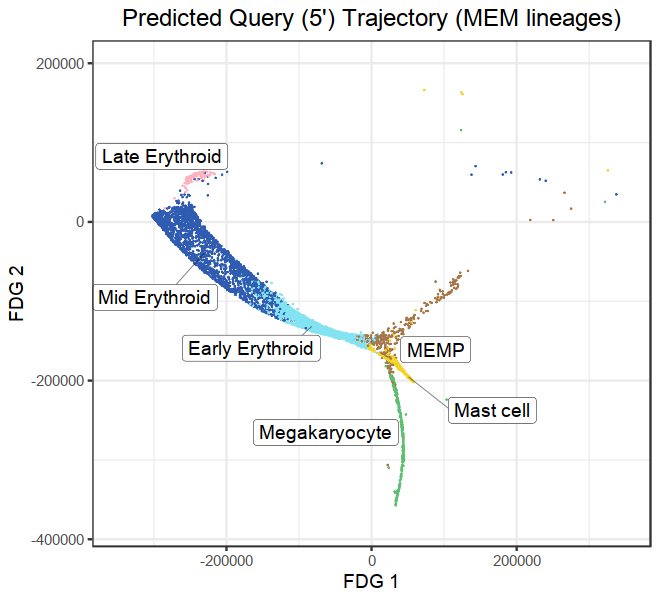

In [152]:
# Plot UMAP visualization
set.seed(123)
options(scipen=10000)
pdf(paste('figs/fdg_5p_query_traj_immuneonly.pdf', sep = ''), height = 5,  width = 5.5, useDingbats=FALSE)
fig.size(5, 5.5)

q =  to_plot %>% 
        sample_frac(1L) %>% # permute rows randomly
        ggplot(aes(x = FDG1, y = FDG2, color = cell.labels)) + 
        geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
        theme_bw() + 
        theme(legend.position = 'none') +
        scale_color_manual(values = group.colors) +
        labs(x = "FDG 1", y = "FDG 2", color = 'Cell type') + 
        theme(legend.position="none", plot.title = element_text(size=14, hjust = 0.5), legend.text = element_text(size=10), 
              legend.key.size = unit(0.9, 'lines')) +
        guides(color=guide_legend(keyheight=0.5, default.unit="cm", override.aes = list(size = 3), ncol = 1)) +
        xlim(-350000, 350000) + ylim(-380000, 200000) +
        labs(title = "Predicted Query (5') Trajectory (MEM lineages)") + 
        ggrepel::geom_label_repel(data = labels.cent, aes(label = cell.labels), segment.alpha = 0.5, segment.size = 0.2,
                    label.size = 0.1, box.padding = 0.01, color = 'black', max.overlaps = 1400)

suppressWarnings(print(q))
dev.off()
suppressWarnings(print(q))

## Plot marker genes

In [153]:
# Normalized query expression
exprs_5p_subset = singlecellmethods::normalizeData(exprs_5p_subset, 1e4, 'log')

In [154]:
metadata_5p_subset$PPBP = exprs_5p_subset['PPBP', ] # Megakaryocyte marker
metadata_5p_subset$HBB = exprs_5p_subset['HBB', ] # Erythoid (RBC) marker
metadata_5p_subset$KIT = exprs_5p_subset['KIT', ] # Mast cell marker 
marker_genes = c('PPBP', 'HBB', 'KIT')

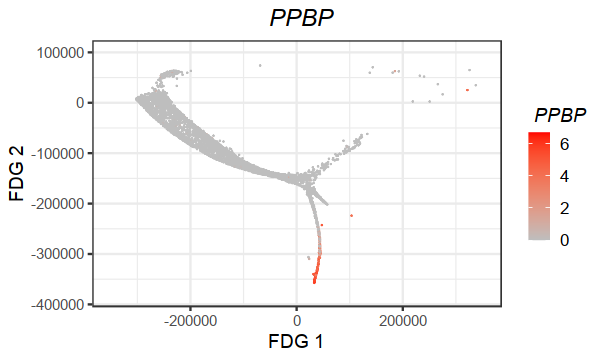

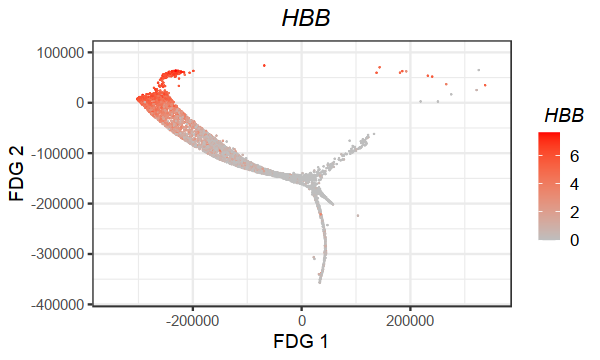

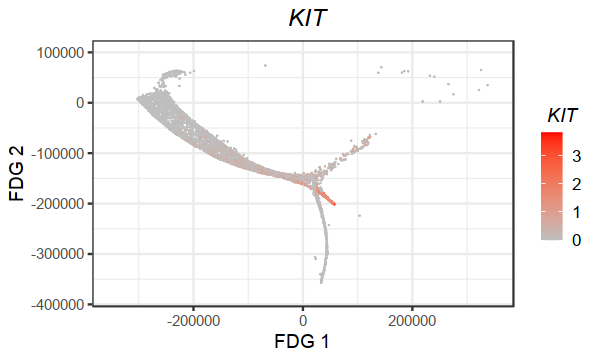

In [155]:
for (gene in marker_genes) {

options(scipen=10000)
pdf(paste('figs/fdg_query_MEM_traj_', gene, '_exprs_noimmune.pdf', sep = ''), height = 3,  width = 5, useDingbats=FALSE)
fig.size(3, 5)

to_plot = data.frame(cbind(FDG1, FDG2)) %>%
            cbind(data.frame(query$meta_data))

q =  to_plot %>% 
        ggplot(aes(x = FDG1, y = FDG2, color = metadata_5p_subset[[gene]])) + 
        geom_point_rast(size = 0.5, stroke = 0.2, shape = 16) +
        theme_bw() + 
        theme(legend.position = 'none') +
        labs(x = "FDG 1", y = "FDG 2", color = substitute(~italic(x), list(x=gene))) + 
        theme(legend.position="right", plot.title = element_text(size=14),
            legend.text = element_text(size=10)) + 
        theme(legend.key.size = unit(0.9, 'lines')) +
        xlim(-350000, 350000) + ylim(-380000, 100000) +
        labs(title = substitute(~italic(x), list(x=gene))) + 
            theme(plot.title = element_text(hjust = 0.5)) +
        scale_colour_gradient(low = 'gray', high = 'red')

suppressWarnings(print(q))
dev.off()
suppressWarnings(print(q))
}

Plot zoom in

png 
  2

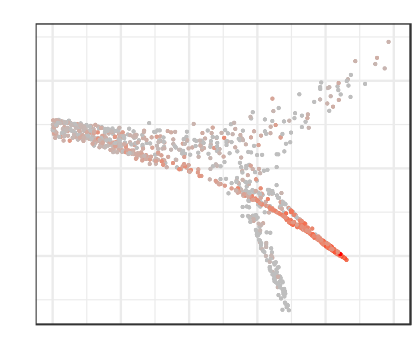

In [156]:
# Plot UMAP visualization
pdf(paste('figs/fdg_query_MEM_traj_KIT_zoom_noimmune.pdf', sep = ''), height = 3,  width = 3, useDingbats=FALSE)
fig.size(3, 3.5)

to_plot = data.frame(cbind(FDG1, FDG2)) %>%
            cbind(data.frame(query$meta_data))

q =  to_plot %>% 
        ggplot(aes(x = FDG1, y = FDG2, color = metadata_5p_subset[['KIT']])) + 
        geom_point_rast(size = 0.8, stroke = 0.2, shape = 19) +
        theme_bw() + 
        labs(x = "", y = "", color = substitute(~italic(x), list(x='KIT'))) + 
        theme(legend.position="none", plot.title = element_text(size=14),
            legend.text = element_text(size=10)) + 
        theme(legend.key.size = unit(0.9, 'lines')) +
        xlim(-50000, 75000) + ylim(-225000, -100000) +
        labs(title = substitute(~italic(x), list(x=''))) + 
            theme(plot.title = element_text(hjust = 0.5)) +
        scale_colour_gradient(low = 'gray', high = 'red') +
        theme(axis.text.x = element_blank(),
          axis.text.y = element_blank(), axis.ticks = element_blank())
suppressWarnings(print(q))
dev.off()
suppressWarnings(print(q))

In [157]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/env_r3.6/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dendextend_1.13.4       circlize_0.4.9          ComplexHeatmap_2.5.3   
 [4] biomaRt_2.42.1          RColorBrewer_1.1-2      symphony_1.0           
 [7] SeuratObject_4.0.0      Seurat_3.9.9.9038       ggrepel_0.9.1          
[10] ggpubr_0.3.0   